<a href="https://colab.research.google.com/github/jarusgnuj/ioctm358/blob/master/notebooks/image_classification/1_keras_fashion_mnist_feed_forward_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Neural Network with Keras

A neural network computation requires a lot of matrix multiplication. It so happens that GPUs are extremely quicker in performing matrix multiplication than CPUs. Python's datastructure like Numpy is great for creating neural networks, but there is not an easy implementation to run numpy codes in a Graphics Processing Unit (GPU). There are many libraries that run processing on GPUs, like Keras, tensorflow, pytorch, torch, etc. All these libraries work on tensors. Tensors are like numpy arrays or matrices but with the added advantage that they can run in both GPUs and CPUs. We will use *Keras* for the rest of the course.

In addition to providing GPU support, Keras also has a vast number of modules that help design, train, and test a neural network very easy. For example, we can use its *Sequential* module to create a neural network, without ever having to think about weights or its dimensions.


## Image Classification

Through this notebook, we will use Keras to implement a neural network architecture that can with high accuracy label an image. We will design a network, then train the network on an image dataset, and finally test it with new unseen data examples.

# Fashion MNIST Dataset

The [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset consists of 28x28 picture grayscale image of a clothing item like t-shirts, jackets, sandals etc. In total, the fashion MNIST dataset consists of 70K images divided into 10 categories. The dataset is large enough for us to use neural networks to accurately classify a clothing item to any of the 10 categories. Each image is of $28X28$ grayscale pixels, i.e. there are total of 784 pixels in an image. Each pixel is of value from 0 to 255 representing from white to gradual change to black.

![](https://github.com/jarusgnuj/ai-ml-wksh/blob/43a0d083c059e7f93023d8f29af87c9682bf02cf/data/image_classification/figures/fashion-mnist-sprite.png?raw=true)

We can download the fashion MNIST dataset from the tensorflow dataset api. For this we need to first install libraries for tensorflow dataset.

In [46]:
!pip install -U tensorflow_datasets

Requirement already up-to-date: tensorflow_datasets in /usr/local/lib/python3.6/dist-packages (1.0.2)


In [0]:
import tensorflow_datasets as input_data
import tensorflow as tf

%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from sklearn.metrics import classification_report, confusion_matrix



We import training and testing data. We train a Neural Network to learn to classify images in the training data and then we use the test data to verify how well the neural network has learnt to classify the images.

![](https://github.com/jarusgnuj/ai-ml-wksh/blob/master/data/image_classification/figures/train-test.jpg?raw=true)

In [48]:
# Import Fashion MNIST

(x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()


print("x_train shape:", x_train.shape)
print("x_test shape:", x_test.shape)

x_train shape: (60000, 28, 28)
x_test shape: (10000, 28, 28)


There are 60k images in training set of $28X28$ pixels and similarly sized 10k images in the test set. The size part will be bit more clear once we view an example image. Actually, lets see one image from the dataset.

The fashion mnist data has 10 categories with value [0, 9]. The different images used are *T-shirt/top, Trouser, Pullover, Dress, Coat, 
 Sandal,  Shirt,   Sneaker,  Bag*,  and  *Ankle boot*

In [0]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

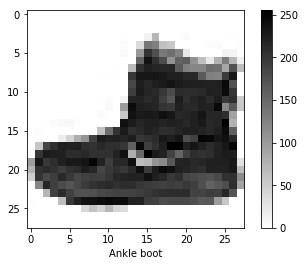

In [50]:
plt.figure()
plt.imshow(x_train[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.xlabel(class_names[y_train[0]])
plt.show()

The colour bar shows the pixel value and its gradient. The value for each pixel in the image is from 0 to 255.

In [51]:
x_train[0][23][10]

185

For a neural network to work efficiently, it is always a good practice to normalise the data between the value [0,1].

In [0]:
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

Let's plot a normalised image data. We will notice the value change in the colour bar.

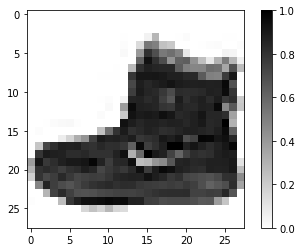

In [53]:
plt.figure()
plt.imshow(x_train[0], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

In [54]:
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

Let's display few of the images from the dataset.

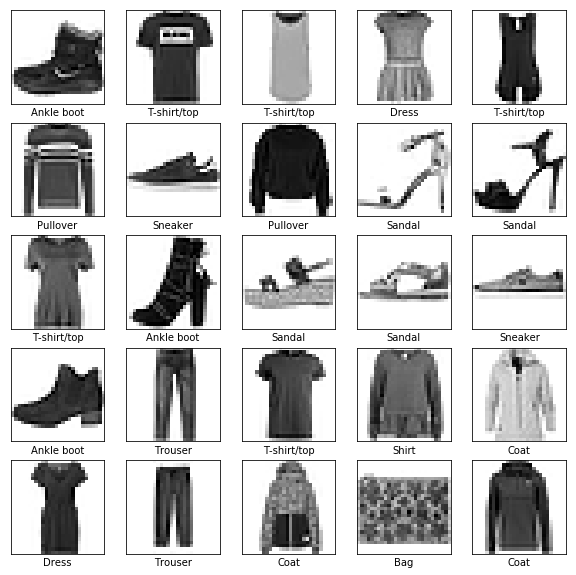

In [55]:
plt.figure(figsize=(10,10))           
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.show()

## Excercise 1: Load similar data points

Change the label names in data1, and data2 below to compare two images.

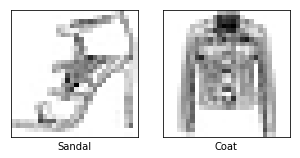

In [77]:
# Exercise 1: Load similar looking data points

data1 = "Sandal"
data2 = "Coat"
v1 =-1
v2 =-1
while True:
  rnd =np.random.randint(60000)
  for im in range (rnd, 60000):
    if class_names[y_train[im]] ==data1:
      v1 = im
    if class_names[y_train[im]] ==data2:
      v2 = im
    if v1!=-1 and v2!=-1:
      break
  if v1!=-1 and v2!=-1:
    break;
plt.figure(figsize=(5,5))
for i in range(2):
    plt.subplot(1,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    if i ==0:
      plt.imshow(x_train[v1], cmap=plt.cm.binary)
      plt.xlabel(class_names[y_train[v1]])
    else:
      plt.imshow(x_train[v2], cmap=plt.cm.binary)
      plt.xlabel(class_names[y_train[v2]])
plt.show()

#The neural network

We will still use the same 3 layered neural network, the only thing we change is the number of inputs (which now is 784) and the number of hidden neurons to 128.

![](https://github.com/jarusgnuj/ai-ml-wksh/blob/master/data/image_classification/figures/feed-forward-fmnist-for-keras.jpg?raw=true)


# Define Model

Models in Keras are defined by stacking layers. Layers in Keras can be a simple feed forward network to complex convolutions layers. A layer takes in a certain number of input and gives a certain number of output. We stack layers in a sequential container. In Keras we need to provide the input dimension for the first layer, the input dimension of following layers are inferrred automatically. We will use feed forward network, which is defined as *Dense* layer in Keras. The only thing we need to be aware is that we are converting the 28x28 pixels image to a 1D (flattened) 784 pixel values. This is done using a *Flatten* layer as a first layer.

In [56]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = (28,28)),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
#     tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(10,  activation=tf.nn.softmax)
])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 784)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               100480    
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1290      
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


#Compile Model

Now that the model is defined, we can compile it.


When compiling, we must specify some additional properties required when training the network. Remember training a network means finding the best set of weights to make predictions for this problem.

We must specify the *loss function* to use to evaluate a set of weights, the *optimizer* used to search through different weights for the network and any *optional metrics* we would like to collect and report during training.

In this case, we will use logarithmic loss, which for a multi class classification problem is defined in Keras as “categorical_crossentropy“. We will also use the efficient gradient descent algorithm “adam”. 
Finally, because it is a classification problem, we will collect and report the classification accuracy as the metric.

In [0]:
model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


#Train Model

We have defined our model and compiled it ready for efficient computation.

Now it is time to execute the model on some data.

We can *train or fit* our model on our loaded data by calling the *fit()* function on the model.

The training process will run for a fixed number of iterations through the dataset called *epochs*, that we must specify using the *epochs* argument. We can also set the number of instances that are evaluated before a weight update in the network is performed, called the batch size and set using the batch_size argument.

For this problem, we will run for a small number of iterations (10) and use a relatively small batch size of 25. Again, these can be chosen experimentally by trial and error.

In [78]:
model.fit(x_train, y_train, batch_size=25, epochs=10)

Epoch 1/10
60000/60000 [==============================] - 8s 127us/sample - loss: 0.3012 - acc: 0.8885
Epoch 2/10
60000/60000 [==============================] - 7s 120us/sample - loss: 0.2734 - acc: 0.8981
Epoch 3/10
60000/60000 [==============================] - 7s 123us/sample - loss: 0.2611 - acc: 0.9027
Epoch 4/10
60000/60000 [==============================] - 8s 125us/sample - loss: 0.2541 - acc: 0.9060
Epoch 5/10
60000/60000 [==============================] - 7s 124us/sample - loss: 0.2412 - acc: 0.9098
Epoch 6/10
60000/60000 [==============================] - 7s 124us/sample - loss: 0.2371 - acc: 0.9120
Epoch 7/10
60000/60000 [==============================] - 7s 120us/sample - loss: 0.2293 - acc: 0.9131
Epoch 8/10
60000/60000 [==============================] - 7s 117us/sample - loss: 0.2202 - acc: 0.9166
Epoch 9/10
60000/60000 [==============================] - 7s 119us/sample - loss: 0.2167 - acc: 0.9177
Epoch 10/10
60000/60000 [==============================] - 7s 123us/sampl

In [79]:
# Evaluate the model on test set
score = model.evaluate(x_test, y_test, verbose=0)
# Print test accuracy
print('\n', 'Test accuracy:', score[1])


 Test accuracy: 0.8781


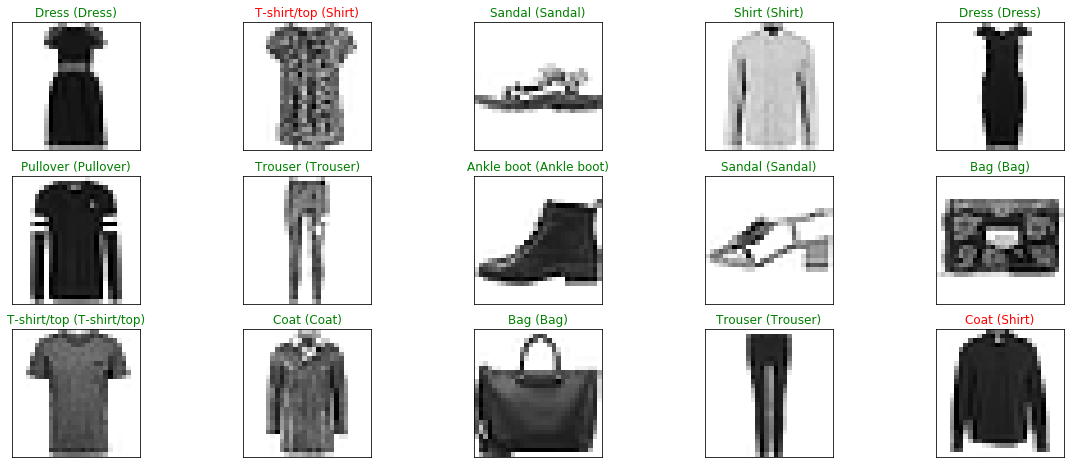

In [60]:


# Plot a random sample of 15 test images, their predicted labels and ground truth
y_hat = model.predict(x_test)
figure = plt.figure(figsize=(20, 8))
for i, index in enumerate(np.random.choice(x_test.shape[0], size=15, replace=False)):
    ax = figure.add_subplot(3, 5, i + 1, xticks=[], yticks=[])
    # Display each image
    ax.imshow(np.squeeze(x_test[index]), cmap=plt.cm.binary)
    predict_index = np.argmax(y_hat[index])
    true_index = y_test[index]
    # Set the title for each image
    ax.set_title("{} ({})".format(class_names[predict_index], 
                                  class_names[true_index]),
                                  color=("green" if predict_index == true_index else "red"))

In [0]:


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [0]:



confusion = confusion_matrix(y_test, np.argmax(y_hat,axis=1))


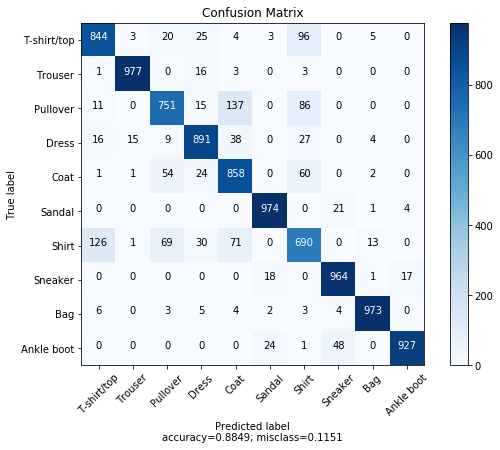

In [63]:
plot_confusion_matrix(confusion, 
                      normalize    = False,
                      target_names = class_names,
                      title        = "Confusion Matrix")

## Excercise 2: Tune Model

Go back to **Train Models** and change:

 - batch_size: To both lower and higher number. Notice change in training speed. Also is there change in accuracy?
 - epochs: to a higher number. Is there any change in accuracy?
 